# Webcam Face's Detection

In [ ]:
!unzip photos.zip

Archive:  photos.zip
   creating: photos/Dorime/
  inflating: photos/Dorime/photo_1_2023-04-30_20-25-18.jpg  
  inflating: photos/Dorime/photo_1_2023-04-30_20-26-19.jpg  
  inflating: photos/Dorime/photo_2_2023-04-30_20-25-18.jpg  
  inflating: photos/Dorime/photo_2_2023-04-30_20-26-19.jpg  
  inflating: photos/Dorime/photo_3_2023-04-30_20-25-18.jpg  
  inflating: photos/Dorime/photo_3_2023-04-30_20-26-19.jpg  
  inflating: photos/Dorime/photo_4_2023-04-30_19-04-42.jpg  
  inflating: photos/Dorime/photo_4_2023-04-30_20-25-18.jpg  
  inflating: photos/Dorime/photo_4_2023-04-30_20-26-19.jpg  
  inflating: photos/Dorime/photo_8_2023-04-30_19-04-42.jpg  
  inflating: photos/Dorime/photo_9_2023-04-30_19-04-42.jpg  
   creating: photos/Kibon/
  inflating: photos/Kibon/photo_1_2023-04-30_19-04-42.jpg  
  inflating: photos/Kibon/photo_1_2023-04-30_20-25-45.jpg  
  inflating: photos/Kibon/photo_2_2023-04-30_20-25-45.jpg  
  inflating: photos/Kibon/photo_3_2023-04-30_20-25-45.jpg  
  inflating: 

In [ ]:
!pip install opencv-python
!pip install keras_vggface
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def replace_line_file(file_name, line, replacement):
  with open(file_name, 'r', encoding='utf-8') as file:
    data = file.readlines()
  
  data[line] = replacement
    
  with open(file_name, 'w', encoding='utf-8') as file:
      file.writelines(data)

replace_line_file("/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py", 19, "from keras.utils.layer_utils import get_source_inputs\n")

# Preprocessing the images used for training

In [ ]:
def detect_face_and_save():
  folder_name = 'photos'

  # dimension of images
  image_width = 224
  image_height = 224

  # for detecting faces
  facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  # set the directory containing the images
  images_dir = os.path.join(".", folder_name)

  current_id = 0
  label_ids = {}

  # iterates through all the files in each subdirectories
  for root, _, files in os.walk(images_dir):
      for file in files:
          if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg"):
              # path of the image
              path = os.path.join(root, file)

              # get the label name (name of the person)
              label = os.path.basename(root).replace(" ", ".").lower()

              # add the label (key) and its number (value)
              if not label in label_ids:
                  label_ids[label] = current_id
                  current_id += 1

              # load the image
              imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
              image_array = np.array(imgtest, "uint8")
              # get the faces detected in the image
              faces = facecascade.detectMultiScale(imgtest, scaleFactor=1.1, minNeighbors=5)

              # if not exactly 1 face is detected, skip this photo
              if len(faces) != 1:
                  print(f'---Photo skipped---\n')

              # save the detected face(s) and associate
              # them with the label
              for (x_, y_, w, h) in faces[:1]:

                  # draw the face detected
                #   face_detect = cv2.rectangle(imgtest,
                #           (x_, y_),
                #           (x_+w, y_+h),
                #           (255, 0, 255), 2)
                #   plt.imshow(face_detect)
                #   plt.show()

                  # resize the detected face to 224x224
                  size = (image_width, image_height)

                  # detected face region
                  roi = image_array[y_: y_ + h, x_: x_ + w]

                  # resize the detected head to target size
                  resized_image = cv2.resize(roi, size)
                  image_array = np.array(resized_image, "uint8")

                  # remove the original image
                  os.remove(path)

                  # replace the image with only the face
                  im = Image.fromarray(image_array)
                  im.save(path)

In [ ]:
detect_face_and_save()

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---



# Build the neural network

In [ ]:
from keras_vggface.vggface import VGGFace

In [ ]:
# Augmenting the Training Images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(   
    './photos',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

# Number of classes we have
n_classes = len(train_generator.class_indices.values())

# Building the model
def generate_model():
    # Use 19 layers from original VGG-Face
    base_model = VGGFace(
        include_top=False,
        model='vgg16',
        input_shape=(224, 224, 3)
    )
    
    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)

    # final layer with softmax activation
    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs = base_model.input, outputs = predictions)

    # Freeze training for the first 19 layers (keep VGG's feature extraction)
    for layer in model.layers[:19]:
        layer.trainable = False

    # Train the rest of the layers - 19 onwards
    for layer in model.layers[19:]:
        layer.trainable = True
    
    return model

generate_model()

Found 41 images belonging to 4 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)

In [ ]:
train_generator

In [ ]:
# Saving the training labels
import pickle

class_dictionary = train_generator.class_indices
class_dictionary = {value:key for key, value in class_dictionary.items()}
print(class_dictionary)

{0: 'Dorime', 1: 'Kibon', 2: 'Ku', 3: 'Unknown'}


In [ ]:
# save the class dictionary to pickle
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)

# Testing the Trained Model

In [ ]:
import cv2
import os
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
import keras.utils as image
from keras_vggface import utils

# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, "rb") as f:
    class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)

['Dorime', 'Kibon', 'Ku', 'Unknown']


Found 2 faces
---We need exactly 1 face; photo skipped---



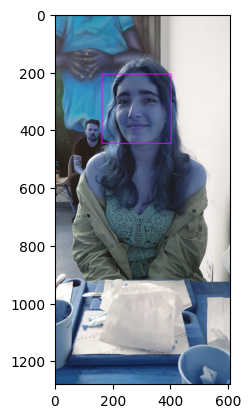

1/1 [==============================] - 0s 368ms/step
[[0. 0. 0. 1.]]
3
Predicted face: Unknown

Found 2 faces
---We need exactly 1 face; photo skipped---



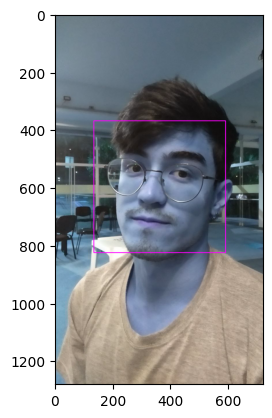

1/1 [==============================] - 0s 30ms/step
[[0. 0. 1. 0.]]
2
Predicted face: Ku



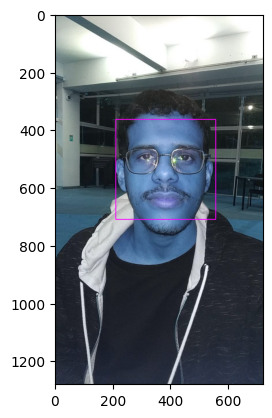

1/1 [==============================] - 0s 36ms/step
[[1. 0. 0. 0.]]
0
Predicted face: Dorime



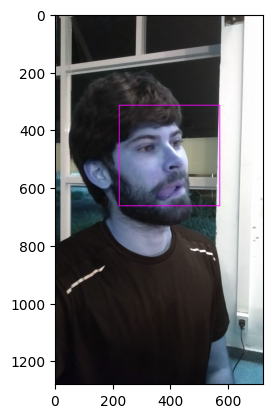

1/1 [==============================] - 0s 47ms/step
[[0.0000000e+00 7.6874479e-30 1.9434334e-36 1.0000000e+00]]
3
Predicted face: Unknown

Found 2 faces
---We need exactly 1 face; photo skipped---



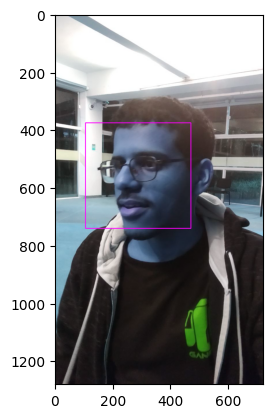

1/1 [==============================] - 0s 37ms/step
[[1. 0. 0. 0.]]
0
Predicted face: Dorime



In [ ]:
# Predicting the faces
facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for i in range(1,6):
    test_image_filename = f'./facetest/face{i}.jpg'

    # load the image
    imgtest = cv2.imread(test_image_filename, cv2.IMREAD_COLOR)
    image_array = np.array(imgtest, "uint8")

    # get the faces detected in the image
    faces = facecascade.detectMultiScale(imgtest, scaleFactor=1.1, minNeighbors=5)

    # if not exactly 1 face is detected, skip this photo
    if len(faces) != 1: 
        print(f"Found {len(faces)} faces")
        print(f'---We need exactly 1 face; photo skipped---')
        print()
        # continue

    for (x_, y_, w, h) in faces[:1]:
        # draw the face detected
        face_detect = cv2.rectangle(imgtest, (x_, y_), (x_+w, y_+h), (255, 0, 255), 2)
        plt.imshow(face_detect)
        plt.show()

        # resize the detected face to 224x224
        size = (image_width, image_height)
        roi = image_array[y_: y_ + h, x_: x_ + w]
        resized_image = cv2.resize(roi, size)

        # prepare the image for prediction
        x = image.img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        x = utils.preprocess_input(x, version=1)

        # making prediction
        predicted_prob = model.predict(x)
        print(predicted_prob)
        print(predicted_prob[0].argmax())
        print("Predicted face: " + class_list[predicted_prob[0].argmax()])
        print("============================\n")

# Real test with webcam

In [ ]:
from PIL import Image
import numpy as np
import cv2
import pickle
from tensorflow.keras.models import load_model

# for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# resolution of the webcam
screen_width = 1280       # try 640 if code fails
screen_height = 720

# size of the image to predict
image_width = 224
image_height = 224

# load the trained model
model = load_model('transfer_learning_trained_face_cnn_model.h5')

# the labels for the trained model
with open("face-labels.pickle", 'rb') as f:
    og_labels = pickle.load(f)
    labels = {key:value for key,value in og_labels.items()}
    print(labels)

# default webcam
stream = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    (grabbed, frame) = stream.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # try to detect faces in the webcam
    faces = face_cascade.detectMultiScale(
        rgb, scaleFactor=1.3, minNeighbors=5)

    # for each faces found
    for (x, y, w, h) in faces: roi_rgb = rgb[y:y+h, x:x+w]

        # Draw a rectangle around the face
        color = (255, 0, 0) # in BGR
        stroke = 2
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, stroke)

        # resize the image
        size = (image_width, image_height)
        resized_image = cv2.resize(roi_rgb, size)
        image_array = np.array(resized_image, "uint8")
        img = image_array.reshape(1,image_width,image_height,3) 
        img = img.astype('float32')
        img /= 255

        # predict the image
        predicted_prob = model.predict(img)

        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        name = labels[predicted_prob[0].argmax()]
        color = (255, 0, 255)
        stroke = 2
        cv2.putText(frame, f'({name})', (x,y-8),
            font, 1, color, stroke, cv2.LINE_AA)

        # Show the frame
        cv2.imshow("Image", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):    # Press q to break out of the loop
            break      

# Cleanup
stream.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

IndentationError: ignored

# K-fold cross validation

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load dataset
def load_dataset():
    (images, labels) = image_dataset_from_directory(
        directory='/photos',
        label_mode='categorical',
        target_size=(224,224),
        color_mode='rgb',
        shuffle=True
    )

    return images, labels

(50000, 32, 32, 3)
(50000, 1)
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

# General definitions
loss_fn = 'categorical_crossentropy'
optimizer = 'Adam'
metrics = ['accuracy']

batch_size = 1
verbose = 1
epochs = 20

num_folds = 5

# Merge inputs and targets
inputs, targets = load_dataset()

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []
for fold_no, (train, test) in enumerate(kfold.split(inputs, targets)):
  # Define the model architecture then compile
  model = generate_model()
  model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(train_generator, batch_size=batch_size, verbose=verbose, epochs=epochs)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

NameError: ignored